In [1]:
%matplotlib inline

import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ttest_ind
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier


# Part 1. Load user_transaction_rates data from pickle
- fill usd na with usd

In [2]:
df = pd.read_pickle('data/rates_usd.pkl')

# df['converted'] = df['amount'] * df['rate']
# df['converted'] = df['converted'].fillna(df['amount'][(df.base_ccy=='USD') &(df.converted.isna())])

# df.to_pickle('data/rates_usd.pkl')

## Dataset contains 688,651 transactions

## What are the distributions of fraudster vs non-fraudster transactions?

In [3]:
is_fraud = df.is_fraudster
is_fraud.value_counts()

False    674108
True      14543
Name: is_fraudster, dtype: int64

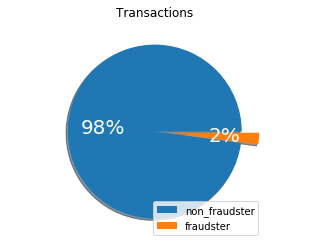

In [4]:
def plot_pie(data=df, feature='is_fraudster', explode=None):

    ax = df[feature].value_counts().plot(kind='pie', shadow=True, explode=explode,
                                             autopct='%0.0f%%', textprops={'color': 'white','size': '20'})

    plt.title('Transactions')
    plt.ylabel('')
    plt.legend(['non_fraudster', 'fraudster'], loc='lower right')
    ax.tick_params(colors='white')
    plt.show()
plot_pie(explode=[0,.2])

## How many unique user_ids are fraudster vs non_fraudster

In [5]:
print("total unique users:",len(df.user_id.unique()))

print("fraudsters:", df[df.is_fraudster==True].groupby('user_id').count().shape[0])

print("non fraudsters:",df[df.is_fraudster==False].groupby('user_id').count().shape[0])

print("fraudster ratio:", df[df.is_fraudster==True].groupby('user_id').count().shape[0]/
       df[df.is_fraudster==False].groupby('user_id').count().shape[0]
       *100,'%')


total unique users: 8021
fraudsters: 299
non fraudsters: 7722
fraudster ratio: 3.872053872053872 %


## What countries are the top 10 fraudsters from, and how many transactions did they make?

In [6]:
top = df[df['is_fraudster']].groupby(['user_id','country'])['amount'].count()
data = pd.DataFrame(top.sort_values(ascending=False))
data = data.rename(columns={'amount': 'transactions'})
display((data.head(10)))

,,transactions
user_id,country,
dc283b17-bbe1-4ae9-a11c-0029d5ae71d9,GB,1029
6eb51e3f-6e8b-45ee-bf01-82495df9c930,GB,590
4ee8690a-ebf7-435b-9fe2-103e8f83edc6,DE,508
25c2ecb3-5ec7-4fa6-8fc3-bbcf3a691217,GB,460
b8271606-4633-4d8f-8729-a2c8ebb8a49f,PL,340
e43ca889-da03-4192-badd-b4f2ca8fb9a1,GB,274
5c75c857-61f0-400e-ac7b-25451c57e8de,GB,238
cb788833-8628-4e70-9095-9f3970e216a5,GB,226
eea32e33-107a-49a5-91c1-3d10b118a154,GB,225


>8 out of the top ten fraudsters are from GB

In [7]:
def plotter(series, title):

    fig, ax = plt.subplots(1,1,figsize=(4,4))
    ax = series.sort_values().plot.barh()
    ax.set_facecolor('white')

    for loc in ['right', 'top', 'bottom']:
        ax.spines[loc].set_visible(False)
    for i, v in enumerate(series.sort_values(ascending=True).tolist()):
        ax.text(v + 1, i, str(v), fontweight='bold')
    plt.xticks([])
    plt.suptitle(title)
    plt.show()
    

# How many fraudster transactions are from GB?

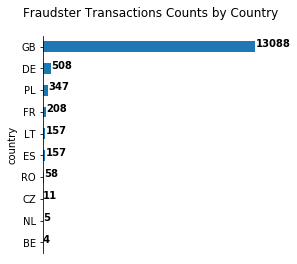

In [8]:
s = df[df['is_fraudster']].groupby('country')['amount'].count()
plotter(s, 'Fraudster Transactions Counts by Country')

## How many unique fraudsters per country?

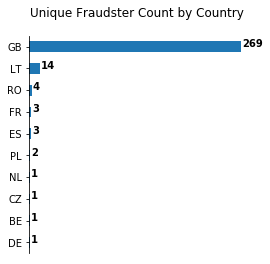

In [9]:
s = pd.Series([x[1] for x in top.index.value_counts().keys()]).value_counts()

plotter(s, 'Unique Fraudster Count by Country')

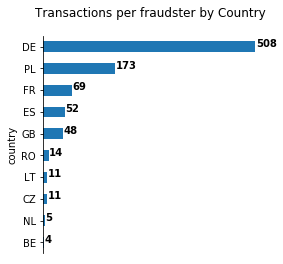

In [10]:
t = df[df['is_fraudster']].groupby('country')['amount'].count()

t_s = (t.sort_index()/s.sort_index())

plotter(t_s.astype(int), 'Transactions per fraudster by Country')


## Great Britain also contains the most fraudulent transactions at 13,088
- GB has an average of 49 transactions per fraudster.

- Germany has 1 fraudster who has made 508 transactions.

>## Special care should be taken to vet users from GB

# How many failed sign in attempts to fraudsters have compared to non fraudsters?

In [11]:
df[df.is_fraudster]['failed_sign_in_attempts'].value_counts()

0    14459
2       46
1       38
Name: failed_sign_in_attempts, dtype: int64

In [12]:
df['failed_sign_in_attempts'].value_counts()

0    684926
1      1787
2      1715
3       143
6        80
Name: failed_sign_in_attempts, dtype: int64

>### Fraudsters do not tend to have more than zero failed sign in attempts. So this should not trigger an alert or a lock.

## What are the total number of zero dollar transactions made by non fraudsters?

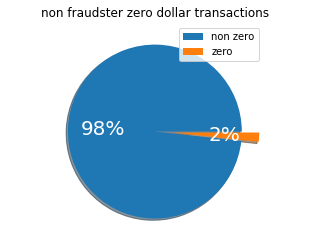

False    662570
True      11538
Name: amount, dtype: int64

In [13]:
(df[~df.is_fraudster].amount==0).value_counts().plot(kind='pie', shadow=True, explode=[0,.2],
                                             autopct='%0.0f%%', textprops={'color': 'white','size': '20'})
plt.title('non fraudster zero dollar transactions')
plt.ylabel('')
plt.legend(['non zero', 'zero'])
plt.show()

display((df[~df.is_fraudster].amount==0).value_counts())

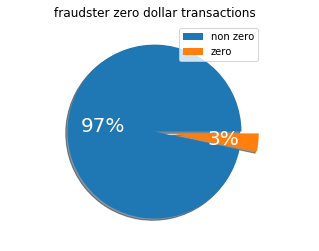

False    14058
True       485
Name: amount, dtype: int64

In [14]:
(df[df.is_fraudster].amount==0).value_counts().plot(kind='pie', shadow=True, explode=[0,.2],
                                             autopct='%0.0f%%', textprops={'color': 'white','size': '20'})
plt.title('fraudster zero dollar transactions')

plt.ylabel('')
plt.legend(['non zero', 'zero'])
plt.show()

display((df[df.is_fraudster].amount==0).value_counts())

>## A zero dollar transaction should warrant at least an alert.


# Part 2. User demographics

In [15]:
df = pd.read_pickle('data/users.pkl')

# How many unique users are there?

In [16]:
df['id'].count()

10300

> There are approximately 10,300 unique user ids

In [17]:
df.head()

,failed_sign_in_attempts,kyc,birth_year,country,state,created_date,terms_version,phone_country,has_email,id,is_fraudster
0,0,PASSED,1971,GB,ACTIVE,2017-08-06 07:33:33.341,2018-05-25,GB||JE||IM||GG,True,1872820f-e3ac-4c02-bdc7-727897b60043,False
1,0,PASSED,1982,GB,ACTIVE,2017-03-07 10:18:59.427,2018-01-01,GB||JE||IM||GG,True,545ff94d-66f8-4bea-b398-84425fb2301e,False
2,0,PASSED,1973,ES,ACTIVE,2018-05-31 04:41:24.672,2018-09-20,ES,True,10376f1a-a28a-4885-8daa-c8ca496026bb,False
3,0,PASSED,1986,FR,ACTIVE,2018-06-01 17:24:23.852,2018-05-25,FR,True,fd308db7-0753-4377-879f-6ecf2af14e4f,False
4,0,PASSED,1989,GB,ACTIVE,2017-08-09 15:03:33.945,2018-09-20,GB||JE||IM||GG,True,755fe256-a34d-4853-b7ca-d9bb991a86d3,False


## how many fraudsters have an email?

In [18]:
df[df['is_fraudster']]['has_email'].value_counts()

True     299
False      1
Name: has_email, dtype: int64

In [19]:
df[~df['is_fraudster']]['has_email'].value_counts()

True     9344
False     656
Name: has_email, dtype: int64

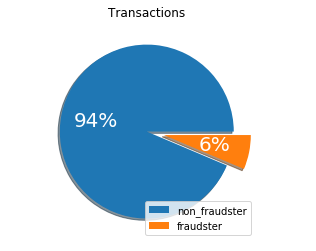

True     299
False      1
Name: has_email, dtype: int64

In [20]:
plot_pie(data=df[df.is_fraudster], feature='has_email',explode=[0,.2])

display(df['has_email'][df.is_fraudster].value_counts())

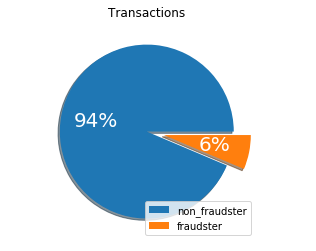

True     9344
False     656
Name: has_email, dtype: int64

In [21]:
plot_pie(data=df[~df.is_fraudster], feature='has_email',explode=[0,.2])

display(df['has_email'][~df.is_fraudster].value_counts())

>## fraudsters tend to have emails, whereas 6% of non fraudsters don't have emails 
- so don't do anything about email

## What is the age distribution of fraudsters?

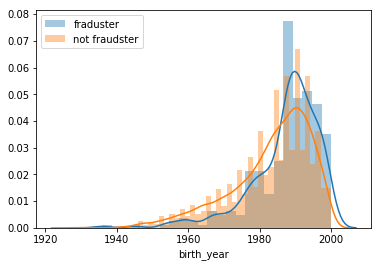

In [22]:
sns.distplot(df[df.is_fraudster]['birth_year'])
sns.distplot(df[~df.is_fraudster]['birth_year'])

plt.legend(['fraduster', 'not fraudster'])

plt.show()

In [23]:
df[df.is_fraudster]['birth_year'].describe()

count     300.000000
mean     1987.270000
std         9.754706
min      1936.000000
25%      1984.000000
50%      1989.000000
75%      1993.250000
max      2000.000000
Name: birth_year, dtype: float64

>## fraudsters and non fraudsters have similar distributions of birth year

In [24]:
ttest_ind(df[df.is_fraudster]['birth_year'], df[~df.is_fraudster]['birth_year'])

Ttest_indResult(statistic=5.945652098661608, pvalue=2.8430168118388986e-09)

>## t-test shows fraudsters tend to be 6 years younger
- Pay extra attention to younger users

In [25]:
df[df.terms_version.isna()]['is_fraudster'].value_counts()

False    1642
True       68
Name: is_fraudster, dtype: int64

>## Null terms version alone does not seem to indicate fraud

# Part 2. Bring in currency data

In [3]:
import pandas as pd

df = pd.read_pickle('../revolut_data/data/rates_usd.pkl')

## What is the distribution of completed transaction USD amounts?

In [4]:
a = df[(df.is_fraudster) & (df.amount >0)&(df.state_x=='COMPLETED')]['converted'].dropna()
b = df[(~df.is_fraudster) & (df.amount >0)&(df.state_x=='COMPLETED')]['converted'].dropna()


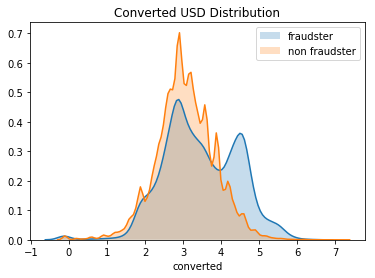

count    6.242660e+05
mean     6.975090e+03
std      7.500541e+04
min      7.347125e-01
25%      3.798428e+02
50%      1.090496e+03
75%      3.739733e+03
max      1.641211e+07
Name: converted, dtype: float64

In [8]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

sns.distplot((np.log10(a)), hist=False, kde_kws={"shade": True})
sns.distplot((np.log10(b)), hist=False, kde_kws={"shade": True})
plt.title('Converted USD Distribution')
plt.legend(['fraudster', 'non fraudster'])
plt.show()

display(df.converted[df.converted>0].describe())

>### Amount distributions are semi normal for fraudsters and non fraudsters

In [9]:
display(a.describe())
display(b.describe())

count    1.009700e+04
mean     2.351364e+04
std      8.129127e+04
min      7.352825e-01
25%      6.282922e+02
50%      2.249811e+03
75%      1.874948e+04
max      2.788607e+06
Name: converted, dtype: float64

count    5.292520e+05
mean     6.495457e+03
std      7.441970e+04
min      7.349852e-01
25%      4.029706e+02
50%      1.089975e+03
75%      3.676875e+03
max      1.641211e+07
Name: converted, dtype: float64

## Do Fraudsters have higher transaction amounts?

In [11]:
from scipy.stats import ttest_ind

ttest_ind(a,b, equal_var=False)

Ttest_indResult(statistic=20.869927604153258, pvalue=8.590603643820517e-95)

>## Fraudsters tend to have higher amount transactions on average.
- so warn on large amount transactions

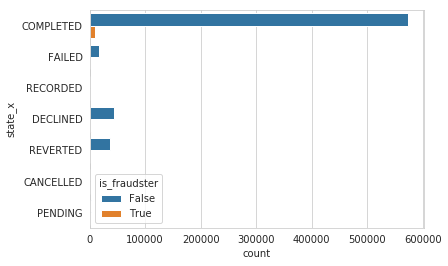

In [12]:
sns.set_style('whitegrid')
sns.countplot(data=df, y='state_x', hue='is_fraudster')

plt.show()

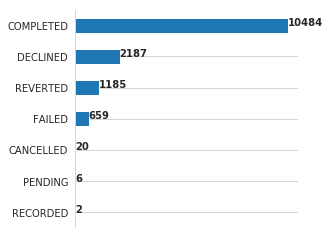

In [13]:
series = df[df.is_fraudster].state_x.value_counts(ascending=True)
fig, ax = plt.subplots(1,1,figsize=(4,4))
ax = series.plot.barh()
ax.set_facecolor('white')

for loc in ['right', 'top', 'bottom']:
    ax.spines[loc].set_visible(False)
for i, v in enumerate(series.sort_values(ascending=True).tolist()):
    ax.text(v + 1, i, str(v), fontweight='bold')
plt.xticks([])

plt.show()


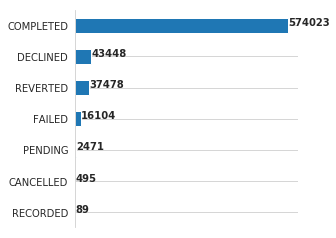

In [14]:
series = df[~df.is_fraudster].state_x.value_counts(ascending=True)
fig, ax = plt.subplots(1,1,figsize=(4,4))
ax = series.plot.barh()
ax.set_facecolor('white')

for loc in ['right', 'top', 'bottom']:
    ax.spines[loc].set_visible(False)
for i, v in enumerate(series.sort_values(ascending=True).tolist()):
    ax.text(v + 1, i, str(v), fontweight='bold')
plt.xticks([])

plt.show()

>## fraudsters complete many transactions and they are also declined many transactions
- provide an alert when a large transaction is declined

# Which merchant categories have the most frequent transactions for fraudsters?

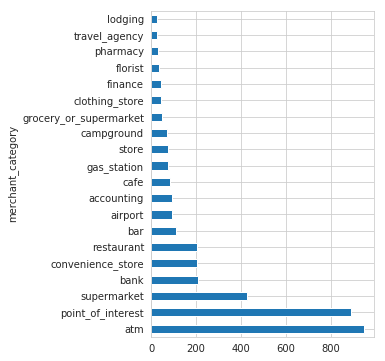

In [15]:
fig = plt.figure(figsize=(4,6))
df[df.is_fraudster].groupby('merchant_category')['converted'].count().sort_values(ascending=False).head(20).plot.barh()

plt.show()

>### Top 20 merchant categories for fraudster transactions are atm, POI(gas station), and supermarket
- alert if a transaction happens at one of these locations


In [16]:
df[df.is_fraudster].groupby('merchant_category')['converted'].count().quantile(.95)

207.2

In [17]:
c_tx = df[(df.is_fraudster) &(df.state_x=='COMPLETED'
                      )].groupby(['merchant_category', 'country']
                                )['converted'].median()

In [18]:
c_tx.quantile(.95)

29874.67853174595

In [19]:
c_tx.sort_values(ascending=False).head(10)

merchant_category  country
jewelry_store      GB         281194.710661
subway_station     GB          58997.824311
bank               GB          38155.626416
accounting         GB          37083.291504
gym                GB          33496.854009
atm                GB          29883.760875
post_office        GB          29823.211921
bank               ES          20045.574242
airport            GB          15003.539389
electronics_store  GB          13399.674177
Name: converted, dtype: float64

## Which merchant countries have the highest median transactions?
- And to what country do the fraudsters who complete these transactions hail from?

In [20]:
c_tx = df[(df.is_fraudster) &(df.state_x=='COMPLETED'
                      )].groupby(['merchant_country', 'country']
                                )['converted'].median()


In [21]:
c_tx.quantile(.95)

17283.260328650893

In [22]:
c_tx.sort_values(ascending=False).head(10)

merchant_country  country
AUT               ES         84899.678865
IND               GB         19285.230690
AUT               FR         17749.890188
ESP               ES         17166.602864
MYS               GB         16242.474723
AUT               GB         13148.741238
ITA               GB          8796.723514
BEL               GB          8703.044762
ESP               FR          7533.818427
CHN               GB          7450.669939
Name: converted, dtype: float64

## Lock users on any high value network transactions
- alert user low value transactions

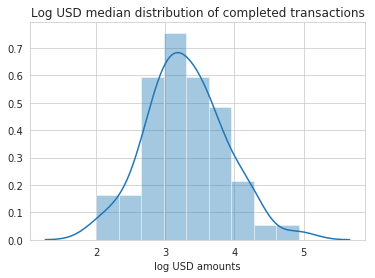

In [23]:
sns.distplot(np.log10(c_tx).dropna())

plt.title('Log USD median distribution of completed transactions')
plt.xlabel('log USD amounts')
plt.show()

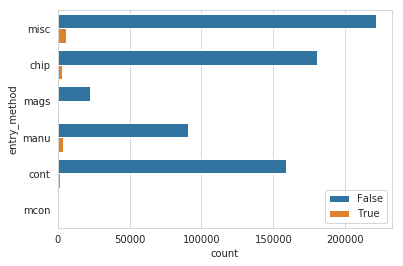

In [24]:
sns.countplot(data=df, y='entry_method', hue='is_fraudster')

plt.legend(loc='lower right')
plt.show()

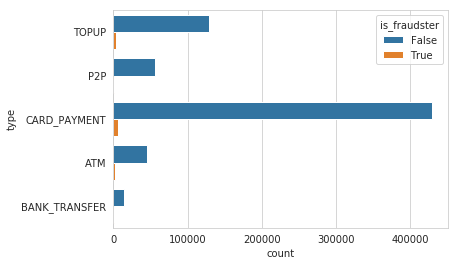

In [25]:
sns.countplot(data=df, y='type', hue='is_fraudster')

plt.show()

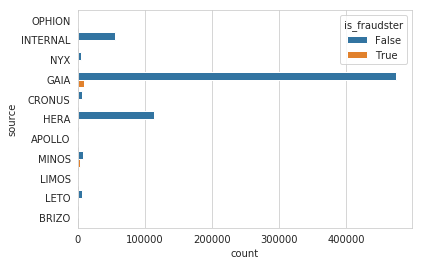

In [26]:
sns.countplot(data=df, y='source', hue='is_fraudster')

plt.show()

## Entry_method misc may yield an alert when combined with other warnings

# Look at phone country and create features

In [27]:
phone = df['phone_country'].str.split(r'\||')
phone = phone.apply(lambda x: [x for x in x if x])
df = df.drop('phone_country', 1)
df = pd.concat([df, phone],1)

/Users/dave-macbook/.local/share/virtualenvs/thinkful-py3-wGzq3gcW/lib/python3.6/site-packages/pandas/core/strings.py:1328: FutureWarning: split() requires a non-empty pattern match.
  f = lambda x: regex.split(x, maxsplit=n)


In [28]:
df['num_phones'] = df['phone_country'].str.join('').str.len()/2

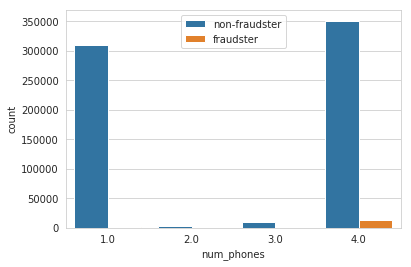

In [29]:
sns.countplot(data=df, x='num_phones', hue='is_fraudster')

plt.legend(['non-fraudster', 'fraudster'], loc='upper center')
plt.show()

>## Fraudsters tend to have 4 phones
- investigate users with multiple phones and other warnings

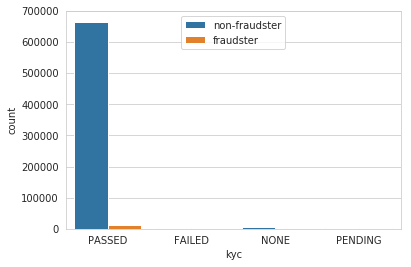

In [30]:
sns.countplot(data=df, x='kyc', hue='is_fraudster')

plt.legend(['non-fraudster', 'fraudster'], loc='upper center')
plt.show()

## Fraudsters tend to have passed kyc
- This passing kyc should not rule out fraudsters

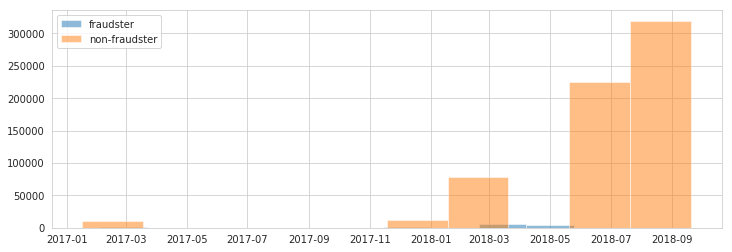

In [31]:

plt.figure(figsize=(12,4))
df[df.is_fraudster]['terms_version'].hist(alpha=.5)
df[~df.is_fraudster]['terms_version'].hist(alpha=.5)

plt.legend(['fraudster', 'non-fraudster'])

plt.show()

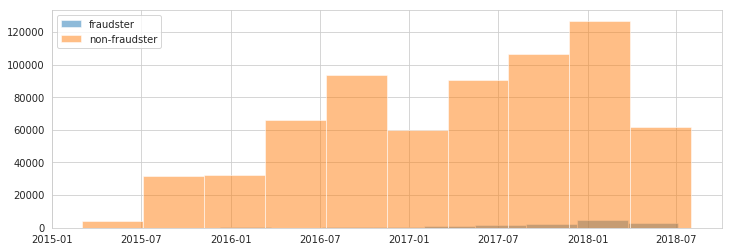

In [32]:
plt.figure(figsize=(12,4))
df[df.is_fraudster]['created_date_y'].hist(alpha=.5)
df[~df.is_fraudster]['created_date_y'].hist(alpha=.5)

plt.legend(['fraudster', 'non-fraudster'])

plt.show()

>### Fraudsters tend to have newer accounts with newer terms dates than non fraudsters

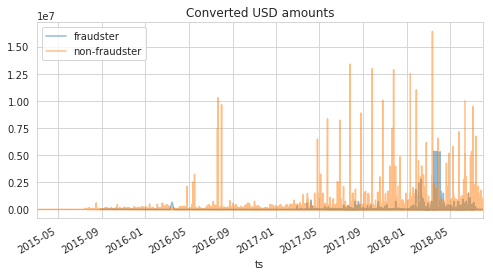

In [33]:
plt.figure(figsize=(8,4))
df[df.is_fraudster].groupby('ts')['converted'].mean().plot(kind='line',alpha=.5)
df[~df.is_fraudster].groupby('ts')['converted'].mean().plot(kind='line',alpha=.5)

plt.legend(['fraudster', 'non-fraudster'])
plt.title('Converted USD amounts')
plt.show()

## Higher amount fraudsters transactions occurred in Q2 2018

## Which currency has the highest median fraudster transactions?

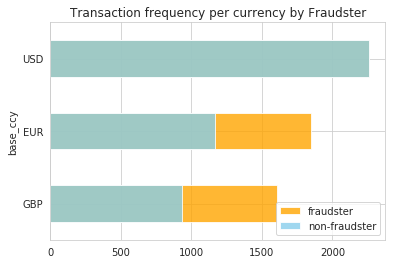

In [34]:
df[(df.is_fraudster==True) & (df.state_x=='COMPLETED')].groupby('base_ccy')['converted'].median().sort_values().head(3).plot.barh(color='orange', alpha=.8)
df[(df.is_fraudster==False) & (df.state_x=='COMPLETED')].groupby('base_ccy')['converted'].median().sort_values().head(3).plot.barh(color='skyblue',alpha=.8)
plt.legend(['fraudster', 'non-fraudster'])
plt.title('Transaction frequency per currency by Fraudster')
plt.show()

## Fraudsters have higher median completed transactions in EURO
- alert when a user transaction is happening with Euros or GBP
- block and alert if user is not from EU or GB

# Build model to classify fraudster

In [35]:
df.head()

,base_ccy,amount,state_x,ts,merchant_category,merchant_country,entry_method,user_id,type,source,...,state_y,created_date_y,terms_version,has_email,is_fraudster,rate,ccy,converted,phone_country,num_phones
0,EUR,2000,COMPLETED,2015-03-03 11:55:44.233,NaN,NaN,misc,23dd04f8-28c8-490c-9a69-2cdffa1e0111,TOPUP,OPHION,...,ACTIVE,2015-03-03 11:38:20.364,NaT,True,False,0.857222,USD,1714.444718,[DE],1.0
1,EUR,500,COMPLETED,2015-03-05 11:33:43.964,NaN,NaN,misc,23dd04f8-28c8-490c-9a69-2cdffa1e0111,P2P,INTERNAL,...,ACTIVE,2015-03-03 11:38:20.364,NaT,True,False,0.858210,USD,429.104937,[DE],1.0
2,GBP,100,COMPLETED,2015-04-28 20:17:15.363,NaN,NaN,misc,73220926-b8eb-405a-90b8-1d770dfb41ec,P2P,INTERNAL,...,ACTIVE,2015-04-28 19:04:36.917,2018-01-13,False,False,0.742613,USD,74.261347,"[RU, KZ]",2.0
3,GBP,1000,COMPLETED,2015-04-28 20:28:19.259,NaN,NaN,misc,73220926-b8eb-405a-90b8-1d770dfb41ec,TOPUP,NYX,...,ACTIVE,2015-04-28 19:04:36.917,2018-01-13,False,False,0.742613,USD,742.613468,"[RU, KZ]",2.0
4,GBP,1000,COMPLETED,2015-04-28 20:56:28.298,NaN,NaN,misc,73220926-b8eb-405a-90b8-1d770dfb41ec,P2P,INTERNAL,...,ACTIVE,2015-04-28 19:04:36.917,2018-01-13,False,False,0.742613,USD,742.613468,"[RU, KZ]",2.0


In [36]:
from sklearn.model_selection import train_test_split

In [37]:
features = pd.get_dummies(df['state_x']=='COMPLETED', 
                          prefix='completed', 
                          drop_first=True)

In [38]:
dummies = [pd.get_dummies(df['merchant_category']==cat, 
                          prefix=cat, 
                         drop_first=True) for cat in ['atm', 'point_of_interest', 'supermarket']]


In [39]:
features = pd.concat([features]+dummies, 1)

In [40]:
features = pd.concat([features, pd.get_dummies(df.country=='GB', 
               prefix='country_GB', 
              drop_first=True)], 1)
                      

# Create feature for merch_country-country
- merchant country-country whose median is above the 95th percentile for fraudster amounts

In [41]:
# AUT               ES         84899.678865
# IND               GB         19285.230690
# AUT               FR         17749.890188
# ESP               ES         17166.602864

In [42]:
d = [pd.get_dummies((df.merchant_country==pair[0]) & (
    df.country==pair[1]), prefix=pair[0]+'_'+pair[1], drop_first=True) for pair in [('AUT', 'ES'), ('IND', 'GB'),
            ('AUT', 'FR'), ('ESP', 'ES')]]
    
    

In [43]:
features = pd.concat([features]+d, 1)

In [44]:
# jewelry_store      GB         281194.710661
# subway_station     GB          58997.824311
# bank               GB          38155.626416
# accounting         GB          37083.291504
# gym                GB          33496.854009
# atm                GB          29883.760875
# post_office        GB          29823.211921
# bank               ES          20045.574242

In [45]:
d = [pd.get_dummies((df.merchant_category==pair[0]) & (
    df.country==pair[1]), prefix=pair[0]+'_'+pair[1], drop_first=True
                   ) for pair in [('jewelry_store','GB'),
                                  ('subway_station','GB'),
                                  ('accounting', 'GB'), 
                                  ('gym', 'GB'),
                                 ('atm', 'GB'),
                                 ('atm', 'GB'),
                                 ('post_office', 'GB'),
                                 ('bank', 'ES')]]

In [46]:
features = pd.concat([features]+d, 1)

## create num_phones features

In [47]:
f = pd.get_dummies(df['num_phones'] ==4, 
               prefix='4_phones',
               drop_first=True)

In [48]:
features = pd.concat([features,f], 1)

In [49]:
f = pd.get_dummies(df['birth_year']> 1990,
                  prefix='birth_year_1990',
                  drop_first=True)

In [50]:
features = pd.concat([features,f], 1)

In [51]:
f = features.dropna()

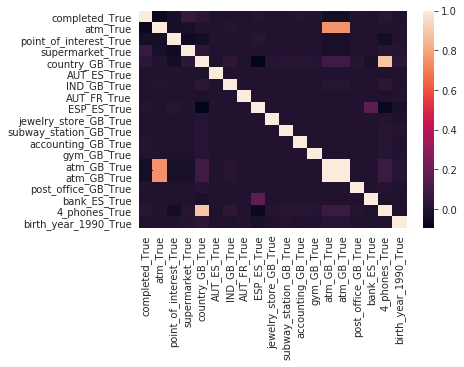

In [53]:
sns.heatmap(f.corr())

In [54]:
f = f.drop(['atm_True', 'country_GB_True'], 1)

In [55]:
X = features
y = df['is_fraudster']

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [58]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=50, random_state=0, n_jobs=4)

rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=4,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [59]:
rfc.score(X_test,y_test)

0.9792567820289982

In [62]:
from sklearn.model_selection import cross_val_score
cross_val_score(rfc, X, y, n_jobs=4, cv=5)

array([0.97887912, 0.97887912, 0.97868309, 0.97885703, 0.97885703])

# accuracy is 97.93% with random forest

## if a user transaction is predicted to be fraudster BOTH alert, and lock the user until the alert can be verified.
- Becuase the model is accurate, locking a user card should have little ramifications on user experience